# Cite-seq / scRNA-seq harmonization

## Imports and data loading

In [1]:
import gzip
import os
import sys
import scipy.io
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import torch

import scvi
from scvi.dataset import GeneExpressionDataset, CellMeasurement, AnnDatasetFromAnnData
from scvi.models import VAE, TOTALVI, Classifier
from scvi.inference import TotalPosterior, TotalTrainer, Posterior, UnsupervisedTrainer

import anndata
import scanpy as sc
import umap
import copy

import scanorama
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import normalize

sys.path.append("../utils/")
from utils import *

save_path = "/data/yosef2/users/adamgayoso/projects/totalVI_journal/data/"

os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID" 
os.environ['CUDA_VISIBLE_DEVICES']='2'

set_seed(123)

%load_ext autoreload
%autoreload 2
%matplotlib inline
overwrite = True


/data/yosef2/users/adamgayoso/.pyenv/versions/scvi/lib/python3.7/site-packages/sklearn/externals/six.py:31: DeprecationWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", DeprecationWarning)


In [2]:
colors = ["#3B7EA1", "#FDB515", "#D9661F", "#859438", "#EE1F60", "#00A598"]
sns.set(context="notebook", font_scale=1.3, style="ticks")
sns.set_palette(sns.color_palette(colors))
plt.rcParams['svg.fonttype'] = 'none'
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['savefig.transparent'] = True
plt.rcParams['figure.figsize'] = (4, 4)

sc.settings._vector_friendly = True
DPI = 300
W_SPACE = 0.18

Load 111 d1 and 111 d2

In [3]:
anndataset_111 = anndata.read(save_path + "spleen_lymph_111.h5ad")

Remove unnecessary proteins

In [4]:
keep_pro_111 = np.array([not p.startswith("HTO") for p in anndataset_111.uns["protein_names"]])
anndataset_111.obsm["protein_expression"] = anndataset_111.obsm["protein_expression"][:, keep_pro_111]
anndataset_111.uns["protein_names"] = anndataset_111.uns["protein_names"][keep_pro_111]

anndataset_111_d1 = anndataset_111[anndataset_111.obs["batch_indices"] == 0]
anndataset_111_d2 = anndataset_111[anndataset_111.obs["batch_indices"] == 1]
# gets incremeted later
anndataset_111_d2.obs["batch_indices"] -= 1

Trying to set attribute `.obs` of view, making a copy.


Create scVI dataset objects

In [5]:
hvg_111 = anndataset_111.var["hvg_encode"]

dataset_111_d1 = AnnDatasetFromAnnData(ad=anndataset_111_d1[:, hvg_111])
protein_data_111 = CellMeasurement(
    name="protein_expression",
    data=anndataset_111_d1.obsm["protein_expression"].astype(np.float32),
    columns_attr_name="protein_names",
    columns=anndataset_111_d1.uns["protein_names"],
)
dataset_111_d1.initialize_cell_measurement(protein_data_111)
dataset_111_d1.gene_names = anndataset_111_d1[:, hvg_111].var_names.values

dataset_111_d2 = AnnDatasetFromAnnData(ad=anndataset_111_d2[:, hvg_111])
protein_data_111 = CellMeasurement(
    name="protein_expression",
    data=anndataset_111_d2.obsm["protein_expression"].astype(np.float32),
    columns_attr_name="protein_names",
    columns=anndataset_111_d2.uns["protein_names"],
)
dataset_111_d2.initialize_cell_measurement(protein_data_111)
dataset_111_d2.gene_names = anndataset_111_d2[:, hvg_111].var_names.values

[2020-04-29 18:08:54,016] INFO - scvi.dataset.dataset | Remapping batch_indices to [0,N]
[2020-04-29 18:08:54,019] INFO - scvi.dataset.dataset | Remapping labels to [0,N]
[2020-04-29 18:08:54,082] INFO - scvi.dataset.dataset | Computing the library size for the new data
[2020-04-29 18:08:54,144] INFO - scvi.dataset.dataset | Downsampled from 9264 to 9264 cells
[2020-04-29 18:08:54,662] INFO - scvi.dataset.dataset | Remapping batch_indices to [0,N]
[2020-04-29 18:08:54,664] INFO - scvi.dataset.dataset | Remapping labels to [0,N]
[2020-04-29 18:08:54,717] INFO - scvi.dataset.dataset | Computing the library size for the new data
[2020-04-29 18:08:54,768] INFO - scvi.dataset.dataset | Downsampled from 7564 to 7564 cells


Make 111 d2 all zero and store real values. Calculate batch mask. All zero proteins are "imputed", no backprop through them

In [6]:
dataset = GeneExpressionDataset()
# Protein panels intersected
dataset.populate_from_datasets(
    [dataset_111_d1, dataset_111_d2],
)

held_out_proteins = dataset.protein_expression[
    dataset.batch_indices.ravel() == 1
].copy()

dataset.protein_expression[dataset.batch_indices.ravel() == 1] = np.zeros_like(
    dataset.protein_expression[dataset.batch_indices.ravel() == 1]
)
batch_mask = dataset.get_batch_mask_cell_measurement("protein_expression")

[2020-04-29 18:08:54,932] INFO - scvi.dataset.dataset | Keeping 4005 genes
[2020-04-29 18:08:55,061] INFO - scvi.dataset.dataset | Computing the library size for the new data
[2020-04-29 18:08:55,160] INFO - scvi.dataset.dataset | Remapping batch_indices to [0,N]
[2020-04-29 18:08:55,163] INFO - scvi.dataset.dataset | Remapping labels to [0,N]
[2020-04-29 18:08:55,269] INFO - scvi.dataset.dataset | Computing the library size for the new data
[2020-04-29 18:08:55,350] INFO - scvi.dataset.dataset | Remapping batch_indices to [0,N]
[2020-04-29 18:08:55,353] INFO - scvi.dataset.dataset | Remapping labels to [0,N]
[2020-04-29 18:08:55,850] INFO - scvi.dataset.dataset | Remapping batch_indices to [0,N]
[2020-04-29 18:08:55,853] INFO - scvi.dataset.dataset | Remapping labels to [0,N]
[2020-04-29 18:08:55,858] INFO - scvi.dataset.dataset | Keeping 110 columns in protein_expression


In [7]:
# Batch mask for second batch should be all 0 because it's proteins are held-out
batch_mask[1]

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False])

## Model creation and training

In [8]:
model = TOTALVI(
    dataset.nb_genes,
    dataset.protein_expression.shape[1],
    n_latent=20,
    n_batch=dataset.n_batches,
    encoder_batch=True,
    protein_batch_mask=batch_mask,
)

use_cuda = True
lr = 4e-3
early_stopping_kwargs = {
    "early_stopping_metric": "elbo",
    "save_best_state_metric": "elbo",
    "patience": 45,
    "threshold": 0,
    "reduce_lr_on_plateau": True,
    "lr_patience": 30,
    "lr_factor": 0.6,
    "posterior_class": TotalPosterior,
}

trainer = TotalTrainer(
    model,
    dataset,
    train_size=0.9,
    test_size=0.1,
    use_cuda=use_cuda,
    frequency=1,
    data_loader_kwargs={"batch_size": 256, "pin_memory":False},
    early_stopping_kwargs=early_stopping_kwargs,
    use_adversarial_loss=True,
    kappa=None
)

In [9]:
trainer.train(lr=lr, n_epochs=500)

[2020-04-29 18:22:11,037] INFO - scvi.inference.trainer | Reducing LR on epoch 210.
[2020-04-29 18:24:46,710] INFO - scvi.inference.trainer | Reducing LR on epoch 269.
[2020-04-29 18:26:45,384] INFO - scvi.inference.trainer | Reducing LR on epoch 311.
[2020-04-29 18:27:32,349] INFO - scvi.inference.trainer | 
Stopping early: no improvement of more than 0 nats in 45 epochs
[2020-04-29 18:27:32,351] INFO - scvi.inference.trainer | If the early stopping criterion is too strong, please instantiate it with different parameters in the train method.


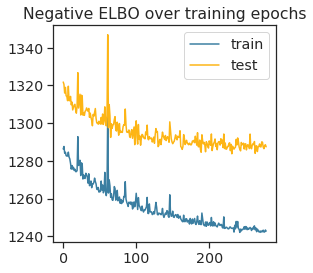

In [10]:
plt.plot(trainer.history["elbo_train_set"][50:], label="train")
plt.plot(trainer.history["elbo_test_set"][50:], label="test")
plt.title("Negative ELBO over training epochs")
plt.legend()

## Posterior creation and analysis

In [11]:
# create posterior on full data
full_posterior = trainer.create_posterior(
    model, dataset, indices=np.arange(len(dataset)), type_class=TotalPosterior
)
# extract latent space
latent_mean, batch_index, label, library_gene = full_posterior.sequential().get_latent()

# denoised has shape n_cells by (n_input_genes + n_input_proteins) with protein features concatenated to the genes
denoised_genes, denoised_proteins = full_posterior.sequential().get_normalized_denoised_expression(
    n_samples=25, give_mean=True, transform_batch=0
)


In [12]:
protein_means = full_posterior.sequential().get_protein_mean(n_samples=25, transform_batch=0, give_mean=True)
# protein_means = np.median(protein_means, axis=-1)
imputed_proteins = protein_means[dataset.batch_indices.ravel() == 1]

In [13]:
post_adata = anndata.AnnData(X=dataset.X)
post_adata.var.index = dataset.gene_names
post_adata.obsm["X_totalVI"] = latent_mean
sc.pp.neighbors(post_adata, use_rep="X_totalVI", n_neighbors=25, metric="correlation")
sc.tl.umap(post_adata, min_dist=0.3, n_components=2)
sc.tl.leiden(post_adata, key_added="leiden_totalVI", resolution=0.6)
names = ["SLN111-D1", "SLN111-D2 No proteins"]
post_adata.obs["batch_indices"] = np.array([names[b] for b in dataset.batch_indices.ravel()])

/data/yosef2/users/adamgayoso/.pyenv/versions/scvi/lib/python3.7/site-packages/umap/nndescent.py:92: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../../.pyenv/versions/scvi/lib/python3.7/site-packages/umap/utils.py", line 409:
@numba.njit(parallel=True)
def build_candidates(current_graph, n_vertices, n_neighbors, max_candidates, rng_state):
^

  current_graph, n_vertices, n_neighbors, max_candidates, rng_state
/data/yosef2/users/adamgayoso/.pyenv/versions/scvi/lib/python3.7/site-packages/numba/compiler.py:602: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/p

Trying to set attribute `.obs` of view, making a copy.
... storing 'batch_indices' as categorical


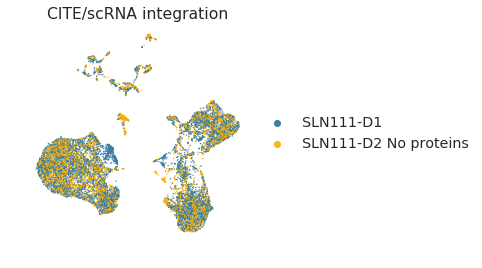

In [14]:
perm_inds = np.random.permutation(len(post_adata))
fig = sc.pl.umap(
    post_adata[perm_inds], 
    color=["batch_indices"],
    title="CITE/scRNA integration",
    return_fig=True,
    frameon=False
)
# sns.despine(fig=fig)
plt.savefig("figures/cite_scrna_umap.pdf", dpi=DPI, bbox_inches="tight")

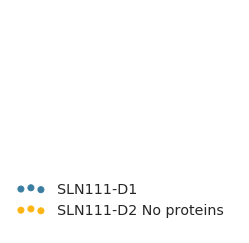

In [15]:
fig, ax = plt.subplots(1, 1)
ax.scatter([], [], label=names[0])
ax.scatter([], [], label=names[1])
ax.legend(frameon=False, scatterpoints=3, loc='lower right')
sns.despine(left=True, bottom=True)
plt.xticks([])
plt.yticks([])
fig.savefig("figures/cite_scrna_legend.pdf", dpi=DPI)

In [16]:
post_adata_b1 = post_adata[dataset.batch_indices.ravel() == 1].copy()
percentiles = {}
for i, p_long in enumerate(dataset.protein_names):
    p = p_long.split("_")[1].split("(")[0]
    post_adata_b1.obs["{} imputed".format(p)] = np.log1p(imputed_proteins[:, i])
    post_adata_b1.obs["{} observed".format(p)] = np.log1p(held_out_proteins[:, i])
    percentiles[p] = np.percentile(np.log1p(held_out_proteins[:, i]), 99)

... storing 'batch_indices' as categorical


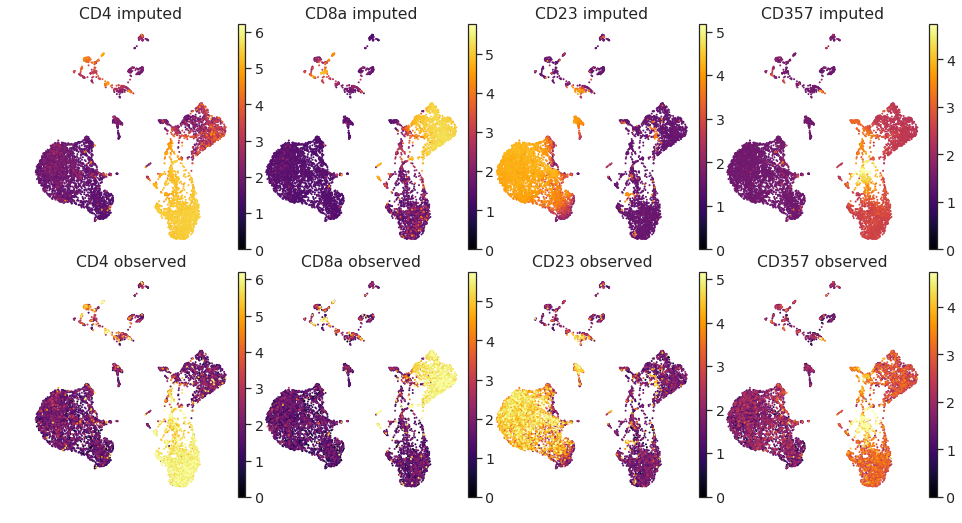

In [17]:
perm_inds = np.random.permutation(len(post_adata))
proteins = ["CD4", "CD8a", "CD23", "CD357"]
colors = np.concatenate([[[p + " imputed"]  for p in proteins] + [[p + " observed"] for p in proteins]]).ravel()
vmax = [percentiles[p] for p in proteins]
vmax += vmax
fig = sc.pl.umap(
    post_adata_b1, 
    color=colors,
    return_fig=True,
    frameon=False,
    color_map="inferno",
    ncols=4,
#     vmax=[None] * 4 + ["p99"] * 4
    vmax = vmax,
    vmin = 0,
    wspace=0.003,
    hspace=0.1
)
plt.savefig("figures/imputed_vs_obs_umaps.pdf", dpi=DPI, bbox_inches="tight")

In [18]:
errors = pd.DataFrame(index = [p.split("_")[1] for p in dataset.protein_names], columns=["totalVI", "Seurat v3"])
corrs = pd.DataFrame(index = [p.split("_")[1] for p in dataset.protein_names], columns=["totalVI", "Seurat v3"])
pear_corrs = pd.DataFrame(index = [p.split("_")[1] for p in dataset.protein_names], columns=["totalVI", "Seurat v3"])

In [19]:
def calc_error(arr1, arr2, selection=None):
    if selection is None:
        e = np.mean(np.abs(arr1 - arr2))
    else:
        e = np.mean(
            np.abs(arr1[selection] - arr2[selection])
        )
    return e

In [20]:
from scipy.stats import pearsonr, spearmanr

plot = False

if plot:
    fig, axarr = plt.subplots(22, 5, figsize=(20, 72))
for i in range(len(dataset.protein_names)):
    if plot is True:
        axarr.flat[i].scatter(
            held_out_proteins[:, i] + 1, imputed_proteins[:, i] + 1, s=0.7, rasterized=True,
        )
        axarr.flat[i].set_yscale('log')
        axarr.flat[i].set_xscale('log')
    s_corr = spearmanr(imputed_proteins[:, i], held_out_proteins[:, i])[
        0
    ]
    p_corr = pearsonr(np.log1p(imputed_proteins[:, i]), np.log1p(held_out_proteins[:, i]))[
        0
    ]
    error = np.round(calc_error(imputed_proteins[:, i], held_out_proteins[:, i]), 3)
    corrs.loc[dataset.protein_names[i].split("_")[1], "totalVI"] = s_corr
    pear_corrs.loc[dataset.protein_names[i].split("_")[1], "totalVI"] = p_corr
    errors.loc[dataset.protein_names[i].split("_")[1], "totalVI"] = error

    if plot is True:
        axarr.flat[i].set_title(
            dataset.protein_names[i].split("_")[1]
            + "\nMAE: {0:.{1}f}".format(error, 3)
        )
        axarr.flat[i].set_xlabel("Observed")
        axarr.flat[i].set_ylabel("Imputed")
if plot is True:
    plt.tight_layout()
    sns.despine()
    plt.tight_layout()
    fig.savefig("figures/imputed_vs_observed_totalVI.pdf", bbox_inches="tight", dpi=DPI)

### Code to create dataset for input to Seurat

In [21]:
# batch_0_rna = pd.DataFrame(
#     dataset.X[dataset.batch_indices.ravel() == 0].T,
#     index=dataset.gene_names,
#     columns=anndataset_111_d1.obs.index,
#     dtype=np.float32,
# )
# batch_0_pro = pd.DataFrame(
#     dataset.protein_expression[dataset.batch_indices.ravel() == 0].T,
#     index=dataset.protein_names,
#     columns=anndataset_111_d1.obs.index,
#     dtype=np.float32,
# )

# batch_1_rna = pd.DataFrame(
#     dataset.X[dataset.batch_indices.ravel() == 1].T,
#     index=dataset.gene_names,
#     columns=anndataset_111_d2.obs.index,
#     dtype=np.float32,
# )

# save_path_csv = "/data/yosef2/users/adamgayoso/projects/totalVI_journal/data/raw_data/"

# batch_0_rna.to_csv(save_path_csv + "sln_d1_harmo_rna_seurat.csv.gz")
# batch_0_pro.to_csv(save_path_csv + "sln_d1_harmo_pro_seurat.csv.gz")
# batch_1_rna.to_csv(save_path_csv + "sln_d2_harmo_rna_seurat.csv.gz")

In [22]:
seurat_imputed = pd.read_csv(
    "/data/yosef2/users/adamgayoso/projects/totalVI_journal/harmonization/seurat_harmo_results/imputed_sln.csv", 
    index_col=0,
).transpose()

In [23]:
plot = False
if plot is True:
    fig, axarr = plt.subplots(40, 3, figsize=(12, 140))
for i in range(len(dataset.protein_names)):
    if plot is True:
        axarr.flat[i].scatter(
            held_out_proteins[:, i] + 1, seurat_imputed.iloc[:, i] + 1, s=1,
        )
        axarr.flat[i].set_yscale("log")
        axarr.flat[i].set_xscale("log")
    s_corr = spearmanr(seurat_imputed.iloc[:, i], held_out_proteins[:, i])[0]
    p_corr = pearsonr(np.log1p(seurat_imputed.iloc[:, i]), np.log1p(held_out_proteins[:, i]))[0]
    error = np.round(calc_error(seurat_imputed.iloc[:, i], held_out_proteins[:, i]), 3)

    errors.loc[dataset.protein_names[i].split("_")[1], "Seurat v3"] = error
    corrs.loc[dataset.protein_names[i].split("_")[1], "Seurat v3"] = s_corr
    pear_corrs.loc[dataset.protein_names[i].split("_")[1], "Seurat v3"] = p_corr

    if plot is True:
        axarr.flat[i].set_title(
            dataset.protein_names[i].split("_")[1]
            + "\nSpearman: {}\nRMSE: {}".format(np.round(p_corr, 3), error)
        )
        axarr.flat[i].set_xlabel("Observed")
        axarr.flat[i].set_ylabel("Imputed")
if plot is True:
    plt.tight_layout()
    sns.despine()
    plt.tight_layout()

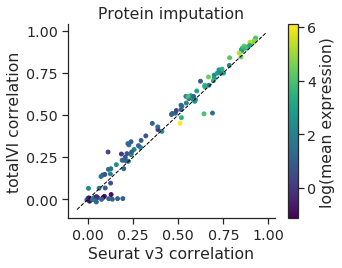

In [24]:
with sns.axes_style("ticks"):

    fig, ax = plt.subplots(figsize=(5, 4))
    avg_exp = np.log(
        np.mean(dataset.protein_expression[dataset.batch_indices.ravel() == 0, :], axis=0)
    )
    a = ax.scatter(
        pear_corrs["Seurat v3"].values.ravel(),
        pear_corrs["totalVI"].values.ravel(),
        s=15,
        c=avg_exp,
        cmap=plt.cm.viridis,
    )
    x = np.linspace(*ax.get_xlim())
    ax.plot(x, x, c="black", linestyle="--", lw=1)
    ax.set_xticks(np.arange(0, 1.25, 0.25))
    ax.set_yticks(np.arange(0, 1.25, 0.25))

    sns.despine()
    ax.set_title("Protein imputation")
    ax.set_ylabel("totalVI correlation")
    ax.set_xlabel("Seurat v3 correlation")
    cbar = plt.colorbar(a)
    cbar.set_label("log(mean expression)")
    plt.tight_layout()
    fig.savefig("figures/correlations_scatter_pearson.pdf", bbox_inches="tight")


In [25]:
pct = np.sum((pear_corrs["totalVI"] / pear_corrs["Seurat v3"]) > 1) / len(errors)
print(pct)

0.7090909090909091
